In [1]:
from src import *
import scipy.sparse.linalg as spsl
import matplotlib.pyplot as plt

In [2]:
# Hamiltonian Parameters
num_qubits = 15
h = 1
J = 1

# Algorithm Parameters
kd_ratio = 2.5
noise_threshold = 0
epsilon = 1e-3
delta_t = 0.083
num_modmd_observables = 6
num_trials = 5

# Analysis Parameters
r = 600
num_predicted_steps = 100
observable_index = 3

In [3]:
# Construct Hamiltonian, get true eigenergies
xx_strings = ['I' * i + 'ZZ' + 'I'* (num_qubits - i - 2) for i in range(num_qubits-1)]
z_strings = ['I' * i + 'X' + 'I'* (num_qubits - i - 1) for i in range(num_qubits)]

sparse_tfim_hamiltonian = SparsePauliOp.from_list([(s,-J) for s in xx_strings] + [(s,-h) for s in z_strings]).to_matrix(sparse=True)

In [4]:
# Construct reference state
indices = np.argsort(sparse_tfim_hamiltonian.diagonal())
reference_state = bitstring_superposition_state(num_qubits,[bin(indices[i])[2:] for i in range(6)])

# Get evolved reference states
K = int(np.round((r+num_predicted_steps+1)/(1+1/kd_ratio)))
d = int(K/kd_ratio)
time_evolution_operator = -1j*sparse_tfim_hamiltonian*delta_t
evolved_reference_states = spsl.expm_multiply(time_evolution_operator,reference_state,start=0,stop=d+K+1,num = d+K+2)

In [5]:
modmd_observables = random_one_local_paulis(num_qubits,num_modmd_observables)
X_elements = generate_X_elements(modmd_observables,d,K,reference_state,evolved_reference_states)

measured_signals = []
predicted_signals = []

for trial in range(num_trials):
    print(f'Trial {trial+1}')

    # Ground truth
    gaussian_noise = np.random.normal(0,epsilon,size=X_elements.shape) + 1j * np.random.normal(0,epsilon,size=X_elements.shape)
    noisy_X_elements = X_elements + gaussian_noise
    measured_signals.append(noisy_X_elements[[observable_index + (i*len(modmd_observables)) for i in range(K+d+1)]])

    # Measure to some K*, extrapolate the rest
    K_star = int(np.round(r/(1+1/kd_ratio)))
    d_star = int(K_star/kd_ratio)
    X,Xp = X_matrices(len(modmd_observables),d_star,K_star,noisy_X_elements)
    A = A_matrix(noise_threshold,X,Xp,False)

    pred = []
    for predicted_step in range(num_predicted_steps):
        Xp = A@Xp
        pred.append(Xp[observable_index - num_modmd_observables,-1])

    predicted_signals.append(pred)

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5


In [6]:
# Results processing
average_measured_signal = np.average(measured_signals,0)[K_star+d_star+1:K_star+d_star+1+num_predicted_steps]
std_measured_signal = np.std(measured_signals,0)[K_star+d_star+1:K_star+d_star+1+num_predicted_steps]

average_predicted_signal = np.average(predicted_signals,0)
std_predicted_signal = np.std(predicted_signals,0)

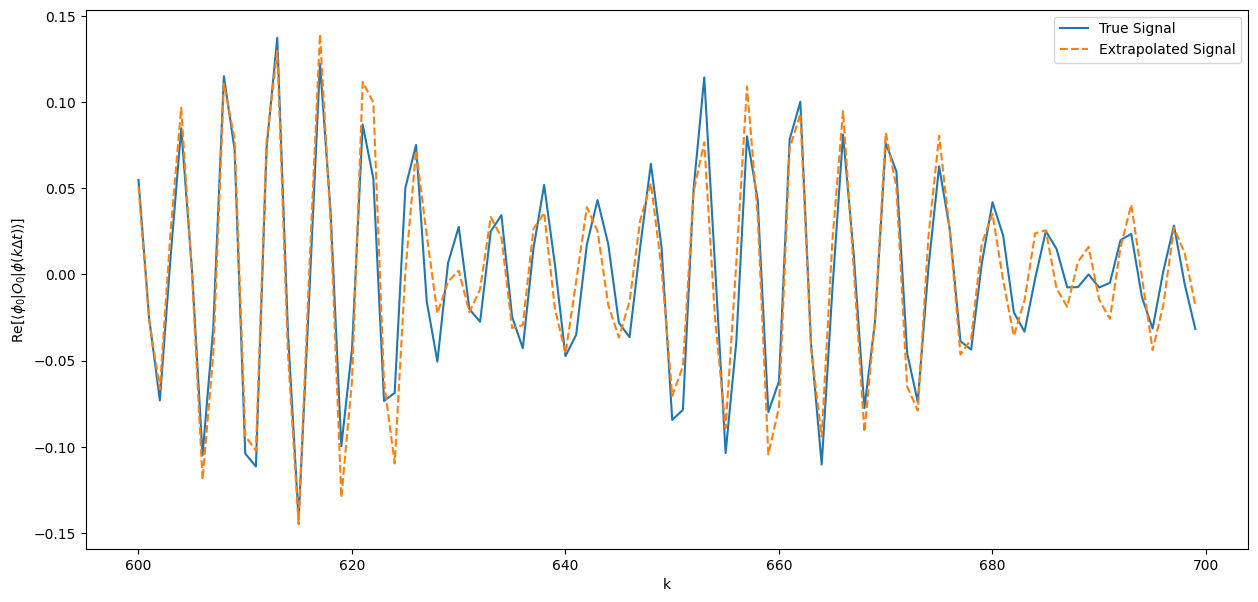

In [7]:
# Get noisy observable signal
colors = ['#c8f0a5','#7bccc4','#43a2ca','#0868ac']
amplitude_type = 'Re'
k_range = range(K_star+d_star,K_star+d_star+num_predicted_steps)

plt.figure(figsize=(15,7))

if amplitude_type == 'Re':
    plt.plot(k_range,average_measured_signal.real, label = 'True Signal')
    plt.plot(k_range, average_predicted_signal.real,'--', label = 'Extrapolated Signal')
elif amplitude_type == 'Im':
    plt.plot(k_range,average_measured_signal.imag, label = 'True Signal', alpha = 1)
    plt.plot(k_range, average_predicted_signal.imag,'--', label = 'Extrapolated Signal', alpha = .7)

plt.xlabel('k')
plt.ylabel(rf'{amplitude_type}[$\langle\phi_0|O_0|\phi(k\Delta t)\rangle$]')
plt.legend()

Text(0, 0.5, 'Absolute Signal Error')

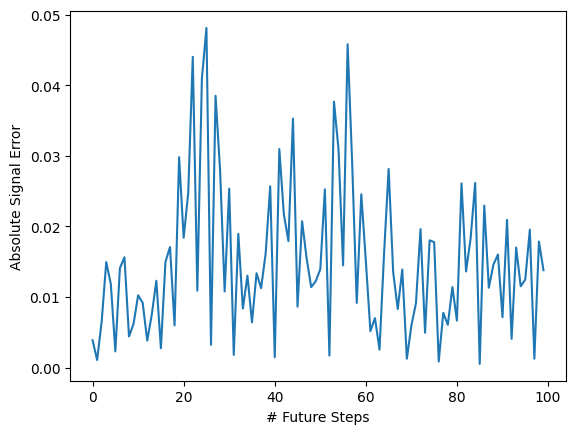

In [8]:
amplitude_type = 'Re'
if amplitude_type == 'Re':
    plt.plot(range(num_predicted_steps),np.abs(average_measured_signal.real-average_predicted_signal.real), label = 'True Signal')
elif amplitude_type == 'Im':
    plt.plot(range(num_predicted_steps),np.abs(average_measured_signal.imag-average_predicted_signal.imag), label = 'True Signal')
plt.xlabel('# Future Steps')
plt.ylabel('Absolute Signal Error')